In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATASETS = 'datasets/sf-police-calls-for-service-and-incidents/'

In [3]:
# import datasets
og_accidents_df = pd.read_csv(DATASETS + 'police-department-incidents.csv')
og_calls_df = pd.read_csv(DATASETS + 'police-department-calls-for-service.csv')

In [4]:
og_calls_df.head(2)

,Crime Id,Original Crime Type Name,Report Date,Call Date,Offense Date,Call Time,Call Date Time,Disposition,Address,City,State,Agency Id,Address Type,Common Location
0,160942891,Muni Inspection,2016-04-03T00:00:00,2016-04-03T00:00:00,2016-04-03T00:00:00,18:15,2016-04-03T18:15:00,Not recorded,900 Block Of Ulloa St,San Francisco,CA,1,Common Location,"West Portal Muni, Sf"
1,160930487,913,2016-04-02T00:00:00,2016-04-02T00:00:00,2016-04-02T00:00:00,03:55,2016-04-02T03:55:00,HAN,Folsom St/13th St,San Francisco,CA,1,Intersection,NaN


In [5]:
og_accidents_df.head(2)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,50436712,ASSAULT,BATTERY,Wednesday,2005-04-20T00:00:00,04:00,MISSION,NONE,18TH ST / CASTRO ST,-122.435003,37.760888,"{'latitude': '37.7608878061245', 'longitude': ...",5043671204134
1,80049078,LARCENY/THEFT,GRAND THEFT FROM A BUILDING,Sunday,2008-01-13T00:00:00,18:00,PARK,NONE,1100 Block of CLAYTON ST,-122.446838,37.762255,"{'latitude': '37.7622550270122', 'longitude': ...",8004907806304


# Questions
1. What are the most common crime types (pie chart)
1. Where are the top common crimes reported at (heat map)
1. throughout 24hrs, when are the call counts for each hour (historgram line chart)
1. throughout 24hrs, where are the most calls for each location at a given hour (heat map)
1. 

In [6]:
def drop_if_count(islessthan, columnname, dataframe):
    hist = dataframe[columnname].value_counts()[::-1]
    labels_to_remove = []
    for label, count in hist.iteritems():
        if count <= islessthan:
            labels_to_remove.append(label)
        else:
            break

    indexes_to_drop = dataframe.loc[dataframe[columnname].isin(labels_to_remove)].index
    
    return dataframe.drop(indexes_to_drop)

In [22]:

# Drop Report Date
calls_df = og_calls_df.drop(columns=['Report Date'], errors='ignore')

# Rearange columns
calls_df = calls_df[['Crime Id', 'Original Crime Type Name', 'Call Date', 'Call Time', 'Call Date Time', 'Offense Date', 'Address', 'City', 'State', 'Address Type', 'Common Location', 'Disposition', 'Agency Id']]

# drop uncommon crimes that are 100 calls or less
calls_df = drop_if_count(islessthan=100, columnname='Original Crime Type Name', dataframe=calls_df)

# drop uncommon common locations that are 100 calls or less
calls_df = drop_if_count(islessthan=100, columnname='Common Location', dataframe=calls_df)

# convert dates into pd.datetime objects
calls_df['Call Date Time'] = pd.to_datetime(calls_df['Call Date Time'])# calls_df.call_datetime.apply(to_datetime)

# Give codes a title
def refactor_codes(value):
    if value == "601":
        return "Trespasser (201)"
    elif value == "909":
        return "Interview a citizen (909)"
    elif value.lower() == "22500e":
        return "Vehicle blocking a (22500e)"
    elif value == "22500f":
        return "Parking on Sidewalk (22500f)"
    elif value.lower() == "rep":
        return "Report (Rep)"

    return value
        
calls_df['Original Crime Type Name'] = calls_df['Original Crime Type Name'].apply(refactor_codes)



# Rename Columns
calls_df = calls_df.rename(columns={
    'Crime Id': 'crime_id',
    'Original Crime Type Name': 'original_crime_type_name',
    'Call Date': 'call_date',
    'Call Time': 'call_time',
    'Call Date Time': 'call_datetime',
    'Offense Date': 'offense_date',
    'Address': 'address',
    'City': 'city',
    'State': 'state',
    'Address Type': 'address_type',
    'Common Location': 'common_location',
    'Disposition': 'disposition',
    'Agency Id': 'agency_id',
})

In [8]:
calls_df.head(1)

,crime_id,original_crime_type_name,call_date,call_time,call_datetime,offense_date,address,city,state,address_type,common_location,disposition,agency_id
0,160942891,Muni Inspection,2016-04-03T00:00:00,18:15,2016-04-03T18:15:00,2016-04-03T00:00:00,900 Block Of Ulloa St,San Francisco,CA,Common Location,"West Portal Muni, Sf",Not recorded,1


In [9]:
# Wrangle accidents_df

# Findings

In [10]:
# Histogram of top 10 calls crime types
# pd.set_option('display.max_rows', 50)
calls_df.original_crime_type_name.value_counts().sort_values(ascending=False)[:10]#.plot(kind='pie')

Passing Call                   264470
Traffic Stop                   216747
Suspicious Person              108030
Homeless Complaint             104216
Vehicle blocking a (22500e)     79348
Muni Inspection                 70420
Audible Alarm                   59653
Suspicious Vehicle              48967
Well Being Check                48794
Fight No Weapon                 42865
Name: original_crime_type_name, dtype: int64

In [11]:
# date range of this data
from datetime import datetime

oldest = calls_df.call_date.min()
latest = calls_df.call_date.max()

# format the date to look pretty here https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
print("Oldest date {}. Most recent date {}".format(oldest, latest))

Oldest date 2016-03-30T00:00:00. Most recent date 2018-10-06T00:00:00


In [12]:
# common locations
calls_df.common_location.value_counts()[:10]

Un Pz, Sf                       6627
Haight St Corridor              5114
One Hallidie Pz, Sf             3863
Twin Peaks Viewpoint, Sf        3863
Powell St Muni, Sf              3616
Un Pz                           3305
Embarcadero Muni Station, Sf    3199
Twin Peaks Viewpoint            2890
Civic Center Muni, Sf           2785
Mission Station, Sf             2780
Name: common_location, dtype: int64

In [13]:
df = calls_df.sort_values(by=['call_datetime'])

In [37]:

# buckets = [-np.inf, 10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf]
# labels = ["0-10", "10-20", "20-30", "40-50", "50-60", "60-70", "70-80", "80-90", "90-100", "100+"]

# pd.cut(x=calls_df.call_datetime, bins=buckets, labels=labels)
def reports_between(start_time, end_time, column, dataframe):
    df = dataframe.set_index(column)
    sliced = df.between_time(start_time, end_time)
    
    return sliced

def value_counts_for(dataframe, column, title):
    hours = ["{}:00".format(hour) for hour in range(24)]
    hours.append("23:59")
    
    hist_df = pd.DataFrame()
    counts = np.array([])
    
    for i in range(len(hours) -1):
        start_time, end_time = hours[i], hours[i +1]
        
        reports = reports_between(start_time, end_time, column, dataframe)
        counts = np.append(counts, len(reports))
        
    display(counts)
        
    hist_df[title] = pd.Series(counts, dtype='int64', index=hours[:-1])
    
    return hist_df

crime_per_hour_df = value_counts_for(calls_df, 'call_datetime', 'Number of Calls')
crime_per_hour_df


array([ 61577.,  47143.,  40268.,  30760.,  27146.,  27645.,  45783.,
        81709.,  95637., 102096., 101029., 102164., 109194., 105367.,
       103085., 106117., 131606., 137843., 126344., 103392.,  82540.,
        81046.,  93227.,  78915.])

,Number of Calls
0:00,61577
1:00,47143
2:00,40268
3:00,30760
4:00,27146
5:00,27645
6:00,45783
7:00,81709
8:00,95637
9:00,102096


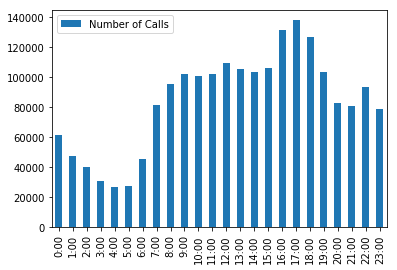

In [48]:
# Number of All Reports throughout the full day
crime_per_hour_df.plot(kind='bar')

In [44]:
# TODO: Find number of reports for the top crimes (Traffic Stop, Suspicious Person, Homeless Complaint, Vehicle blocking a (22500e), Muni Inspection)


# Stats
1. Is there a trend for a given day between 2016 and today?

In [46]:
import statsmodels.api as sm

# create a dataframe that contains the number of crimes for every given hour for every existing datetime
def value_counts_for_every_hour(dateframe, column):
    df = dateframe.set_index(column)

df = value_counts_for_every_hour(calls_df, 'call_datetime')
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
decomposition.plot()

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''